# Simple synchronism test of the XCOM block

The general idea is that the boards are locked to a common reference, a "PPS" signal comming from a GPS for example. In this case we generate a false PPS in the HP 8110A generator. It has two synchronous channels and give us a "typical" PPS signal (200ms high, 800ms low). There is a "leader" board and a "follower" board. The boards are inter-connected through xcom blocks. 

### Hardware setup
We'll use two ZCU216 boards for this setup. The RF cabling is similar to what we use for the standard demos (DAC 228_0 to ADC 224_0), except that the second loopback goes between boards (DAC 229_2 of each board to ADC 224_1 of the other).

# First test the generators and acquisition
The idea here is to test the loopback connection like in 00_intro.ipynb

In [46]:
# jupyter setup boilerplate
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
from qick import *
# for now, all the tProc v2 classes needto be individually imported (can't use qick.*)
# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [47]:
qick.get_version()

'0.2.347'

In [48]:
soc = QickSoc('./tprocv2r21_standard.bit')
soccfg = soc
#print(soccfg)

In [49]:
# ZCU216 standard FW, full-speed gen
GEN_CH = 0
RO_CH = 0
TRIG_TIME = 0.40
FREQ = 500

In [50]:
class MultiPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )

        self.add_pulse(ch=gen_ch, name="myflattop2", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=90,
                       gain=1.0, 
                      )

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.4)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0.8)
        self.pulse(ch=cfg['gen_ch'], name="myflattop2", t=1.2)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=1.6)
        


In [51]:
soc.xcom_0.xcom_cfg = 4

In [52]:
soc.xcom_0.set_local_id(4)
soc.xcom_0.print_axi_regs()

---------------------------------------------
--- AXI Registers
 xcom_ctrl          32 - 0000_0000_0000_0000_0000_0000_0010_0000
  xcom_cfg           4 - 0000_0000_0000_0000_0000_0000_0000_0100
   axi_dt1           4 - 0000_0000_0000_0000_0000_0000_0000_0100
   axi_dt2           0 - 0000_0000_0000_0000_0000_0000_0000_0000
  axi_addr           0 - 0000_0000_0000_0000_0000_0000_0000_0000
  board_id           4 - 0000_0000_0000_0000_0000_0000_0000_0100
      flag           0 - 0000_0000_0000_0000_0000_0000_0000_0000
       dt1           0 - 0000_0000_0000_0000_0000_0000_0000_0000
       dt2           0 - 0000_0000_0000_0000_0000_0000_0000_0000
       mem           0 - 0000_0000_0000_0000_0000_0000_0000_0000
     rx_dt           0 - 0000_0000_0000_0000_0000_0000_0000_0000
     tx_dt           0 - 0000_0000_0000_0000_0000_0000_0000_0000
    status     6881280 - 0000_0000_0110_1001_0000_0000_0000_0000
     debug           0 - 0000_0000_0000_0000_0000_0000_0000_0000


In [53]:
soc.xcom_0.run_cmd(soc.xcom_0.opcodes['XCOM_WRITE_MEM'], 2, 0x5001)

In [54]:
print("{0:5s} {2:12s}".format('addr','\t','xcom_0_mem'))
for i in range(16):
    soc.xcom_0.axi_addr = i
    #soc.xcom_1.axi_addr = i
    print("{0:3d} {2:12d}".format(soc.xcom_0.axi_addr, '\t', soc.xcom_0.mem))
    soc.xcom_0.mem

addr  xcom_0_mem  
  0            0
  1            0
  2        20481
  3            0
  4            0
  5            0
  6            0
  7            0
  8            0
  9            0
 10            0
 11            0
 12            0
 13            0
 14            0
 15            0


In [55]:
soc.xcom_0.print_axi_regs()

---------------------------------------------
--- AXI Registers
 xcom_ctrl          38 - 0000_0000_0000_0000_0000_0000_0010_0110
  xcom_cfg           4 - 0000_0000_0000_0000_0000_0000_0000_0100
   axi_dt1           2 - 0000_0000_0000_0000_0000_0000_0000_0010
   axi_dt2       20481 - 0000_0000_0000_0000_0101_0000_0000_0001
  axi_addr          15 - 0000_0000_0000_0000_0000_0000_0000_1111
  board_id           4 - 0000_0000_0000_0000_0000_0000_0000_0100
      flag           0 - 0000_0000_0000_0000_0000_0000_0000_0000
       dt1           0 - 0000_0000_0000_0000_0000_0000_0000_0000
       dt2           0 - 0000_0000_0000_0000_0000_0000_0000_0000
       mem           0 - 0000_0000_0000_0000_0000_0000_0000_0000
     rx_dt           0 - 0000_0000_0000_0000_0000_0000_0000_0000
     tx_dt       20481 - 0000_0000_0000_0000_0101_0000_0000_0001
    status    13172736 - 0000_0000_1100_1001_0000_0000_0000_0000
     debug           0 - 0000_0000_0000_0000_0000_0000_0000_0000


In [56]:
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1.9
         }

#prog = MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
#
#iq_list = prog.acquire_decimated(soc, soft_avgs=10)
#t = prog.get_time_axis(ro_index=0)
#
#plt.plot(t, iq_list[0][:,0], label="I value")
#plt.plot(t, iq_list[0][:,1], label="Q value")
#plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
#plt.legend()
#plt.ylabel("a.u.")
#plt.xlabel("us");

  0%|          | 0/1 [00:00<?, ?it/s]

-228.20034246575344


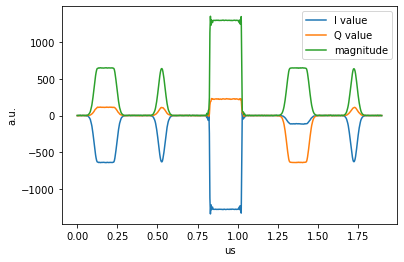

In [74]:
prog = MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10, start_src='external')
#iq_list = prog.acquire_decimated(soc, soft_avgs=10, start_src='internal')

t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

print(np.mean(iq_list[0][:,0]))

In [75]:
import struct

def float_to_binary32(float_value):
    """
    Converts a Python float (double-precision) to its 32-bit IEEE 754
    single-precision binary representation.

    Args:
        float_value (float): The floating-point number to convert.

    Returns:
        str: A string representing the 32-bit binary value (e.g., "01000010110101010001111010111000").
             Returns an error message if conversion fails.
    """
    try:
        # 'f' for float (single-precision), '>' for big-endian byte order
        # '<' for little-endian byte order (more common on x86 systems)
        # We'll use '<' for typical system compatibility.
        # If you need big-endian, change to '>f'
        packed_bytes = struct.pack('<f', float_value)

        # Convert the bytes to an integer
        # 'I' for unsigned int, '<' for little-endian
        integer_representation = struct.unpack('<I', packed_bytes)[0]

        # Convert the integer to a 32-bit binary string
        # bin() returns a string like '0b1010...'
        # [2:] removes the '0b' prefix
        # zfill(32) pads with leading zeros to ensure 32 bits
        binary_string = bin(integer_representation)[2:].zfill(32)

        return binary_string, integer_representation # Return both for hex printing
    except OverflowError:
        return "Error: Value is too large or too small for 32-bit float.", None
    except Exception as e:
        return f"An unexpected error occurred: {e}", None

# The float value to convert
value_to_convert = np.mean(iq_list[0][:,0])

# Perform the conversion
binary_representation, int_rep = float_to_binary32(value_to_convert)

# Print the result
print(f"The float value: {value_to_convert}")
print(f"Its 32-bit binary (IEEE 754 single-precision) representation: {binary_representation}")

# Print the hexadecimal representation
if int_rep is not None:
    print(f"Its 32-bit hexadecimal representation: {hex(int_rep)}")

# You can also manually decode it to verify (for understanding)
# This part is just for demonstration and not part of the conversion function
if len(binary_representation) == 32:
    sign_bit = binary_representation[0]
    exponent_bits = binary_representation[1:9]
    mantissa_bits = binary_representation[9:]

    print("\nBreakdown (IEEE 754 Single-Precision):")
    print(f"  Sign bit:    {sign_bit} (0 for positive, 1 for negative)")
    print(f"  Exponent:    {exponent_bits} (8 bits, biased by 127)")
    print(f"  Mantissa:    {mantissa_bits} (23 bits, implicit leading 1)")

    # Decode the exponent
    exponent_int = int(exponent_bits, 2)
    biased_exponent = exponent_int
    actual_exponent = biased_exponent - 127
    print(f"  Actual Exponent: {actual_exponent}")

    # Decode the mantissa
    # Add the implicit leading '1'
    mantissa_decimal = 1.0
    for i, bit in enumerate(mantissa_bits):
        if bit == '1':
            mantissa_decimal += (2**(-(i + 1)))
    print(f"  Mantissa (decimal): {mantissa_decimal}")

    # Reconstruct the value (for verification)
    reconstructed_value = ((-1)**int(sign_bit)) * mantissa_decimal * (2**actual_exponent)
    print(f"  Reconstructed Value: {reconstructed_value}")

The float value: -228.20034246575344
Its 32-bit binary (IEEE 754 single-precision) representation: 11000011011001000011001101001010
Its 32-bit hexadecimal representation: 0xc364334a

Breakdown (IEEE 754 Single-Precision):
  Sign bit:    1 (0 for positive, 1 for negative)
  Exponent:    10000110 (8 bits, biased by 127)
  Mantissa:    11001000011001101001010 (23 bits, implicit leading 1)
  Actual Exponent: 7
  Mantissa (decimal): 1.7828152179718018
  Reconstructed Value: -228.20034790039062


In [79]:
binary_representation, int_rep = float_to_binary32(np.mean(iq_list[0][:,0]))
print(int_rep)
#soc.xcom_0.run_cmd(soc.xcom_0.opcodes['XCOM_SEND_32BIT_2'], 5, np.mean(iq_list[0][:,0])) #6 means start_proc
soc.xcom_0.run_cmd(soc.xcom_0.opcodes['XCOM_SEND_32BIT_2'], 5, int_rep) #6 means start_proc
print(np.mean(iq_list[0][:,0]), np.min(iq_list[0][:,0]), np.max(iq_list[0][:,0]))

3278123850
-228.20034246575344 -1342.0 83.0


In [ ]:
GEN_CHS = [0]
RO_CHS = [0]
TRIG_TIME = 120 # tProc ticks
FREQ = 500

In [ ]:
class LoopbackProgramV2(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_chs = cfg['gen_chs']
        for gen_ch in gen_chs:
            self.declare_gen(ch=gen_ch, nqz=1)
            
        self.add_pulse(ch=gen_chs,
                      name="mypulse",
                      ro_ch=ro_chs[0],
                      style="const",
                      freq=cfg['freq'],
                      length=cfg['pulse_len'],
                      phase=cfg['gen_phase'],
                      gain=cfg['gen_gain'],
                      )

        for ro_ch in ro_chs:
            self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_chs,
                              name="myro",
                              freq=cfg['freq'],
                              gen_ch=gen_chs[0])

        for ro_ch in ro_chs:
            self.send_readoutconfig(ch=ro_ch,
                                   name="myro",
                                   t=0)
        if cfg['send_start']:
            self.delay(0.5)  # give processor some time to set registers
            self.trigger(pins=[0], t=0) # output a pulse on PMOD0_0, to trigger the follower
            self.delay(cfg['leader_delay']) # give follower time to catch up
                    
    def _body(self, cfg):
        for gen_ch in cfg['gen_chs']:
            self.pulse(ch=gen_ch, name="mypulse", t=0)
        self.trigger(ros=cfg['ro_chs'], t=cfg['trig_time'])
        


In [ ]:
config = \
{
    'gen_chs': GEN_CHS,
    'ro_chs': RO_CHS,
    'freq': FREQ,
    'trig_time': TRIG_TIME-0.2,
    'ro_len': 0.5,
    'pulse_len': 0.05,
    'gen_gain': 1.0,
    'gen_phase': 0.0,
    'send_start': False,
    'leader_delay': 0.05,
}

# soc, soccfg = proxies[1]
# prog = LoopbackProgramV2(soccfg, reps=1, final_delay=0.5, cfg=config)

# iq_list = prog.acquire_decimated(soc, soft_avgs=10, start_src='internal')
# t = prog.get_time_axis(ro_index=0)

# plt.plot(t, iq_list[0][:,0], label="I value")
# plt.plot(t, iq_list[0][:,1], label="Q value")
# plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
# plt.legend()
# plt.ylabel("a.u.")
# plt.xlabel("us");

In [ ]:
prog = LoopbackProgramV2(soccfg, reps=1, final_delay=0.5, cfg=config) #MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10, start_src='external')

t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

In [ ]:
soc.xcom_0.run_cmd(soc.xcom_0.opcodes['XCOM_QCTRL'], 5, 6) #6 means start_proc